In [1]:
from neuron import h
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

from cell_inference.cells.stylizedcell import StylizedCell, CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.ecp import EcpMod, move_position
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.currents.pointcurrent import PointCurrent
from cell_inference.utils.feature_extractors.parameterprediction import Parameters, ClassifierTypes, ClassifierBuilder

from cell_inference.config import params, paths


h.load_file('stdrun.hoc')
h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

#### Set parameters

In [2]:
elec_pos = params.ELECTRODE_POSITION #pos = np.column_stack((x,y,z))
loc_param = [0,0,50,np.pi/4,1,0]  # position (x,y,z,alpha,h,phi)
geo_param = [8.,600.,1.25,.28,.28,200.]  # (soma r,trunk l,trunk r,basal r,tuft r,dend l), bounds([3,12],[20,800],[0.6,2.5],[0.1,0.8],[0.1,0.8],[100,300])
geo_name = ['soma r','trunk l','trunk r','basal r','tuft r','dend l']
biophys = [-1] # (g_pas of soma, basal, apical, gNaTa_t of soma, apical, gSKv3_1 of soma, apical) (3.3e-5, 6.3e-5, 8.8e-5, 2.43, 0.0252, 0.983, 0.0112)

In [3]:
from typing import Union, List, Tuple
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
%matplotlib inline

def sim_builder(geo_var: List[Tuple[int,List[float]]], gmax: float = .01) -> Simulation:
    """ geo_var: List of Tuples ( Parameter entry, List of values ), variable parameters to loop over """
    geo_idx, values = zip(*geo_var)
    geo_params = [x.ravel() for x in np.meshgrid(*values,indexing='ij')]
    ncell = geo_params[0].size
    geo_parameters = np.tile(np.array(geo_param),(ncell,1))
    for idx, val in zip(geo_idx,geo_params):
        geo_parameters[:,idx] = val
    sim = Simulation(geometry = geo_standard, 
                     electrodes = elec_pos, 
                     cell_type = CellTypes.ACTIVE, 
                     loc_param = loc_param, 
                     geo_param = geo_parameters, 
                     biophys = biophys, 
                     ncell = ncell, 
                     spike_threshold = -20, 
                     gmax = gmax, 
                     scale = 1.)  # 0.001 -0.012
    geo_values = np.vstack(geo_params).T
    return sim, geo_idx, geo_values

def plot_v(sim: Simulation, geo_idx: Tuple[int], geo_values: np.ndarray,
           figsize: Union[List[float],Tuple[float]] = (6,2)) -> Tuple[Figure, Axes]:
    t = sim.t()
    v = sim.v('all')
    fig, axs = plt.subplots(nrows=sim.ncell, ncols=1)
    fig.set_size_inches(figsize[0],figsize[1]*sim.ncell)
    for i,ax in enumerate(axs):
        ax.plot(t,v[i,:],label=', '.join(map(str,geo_values[i])))
        ax.set_ylabel('Vm (mV)')
        ax.legend(loc=1)
    axs[0].set_title(', '.join([geo_name[i] for i in geo_idx]))
    axs[-1].set_xlabel('Time (ms)')
    return fig, axs

def valid_count(sim):
    # number of valid spiking cells
    nspk = sim.get_spike_number('all')
    nvalid = np.count_nonzero(nspk == 1)
    return nvalid

#### Initial simulation check

In [4]:
geo_range = [(0,[5.,12.]),(1,[20.,800.])] # soma r 5-12, trunk l 20-800
gmax = 0.01  # select inital gmax

Show cases at geometry parameter bounds.

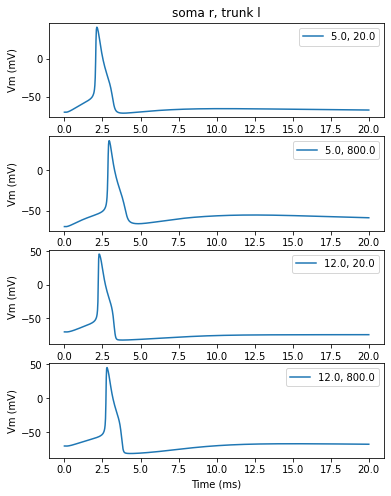

In [5]:
sim, geo_idx, geo_values = sim_builder(geo_range,gmax=gmax)
sim.run_neuron_sim()

_ = plot_v(sim, geo_idx, geo_values)

Search bounds for gmax up to no valid sample. Use bisection to help find the bounds.

In [6]:
from scipy.optimize import bisect

def find_bound(sim,gmax,coarse_bounds,tol):
    def func(g):
        sim.set_gmax(g)
        sim.run_neuron_sim()
        return valid_count(sim)-0.5
    
    xtol = tol*gmax
    glo,r1 = bisect(func,coarse_bounds[0],gmax,xtol=xtol,full_output=True)
    ghi,r2 = bisect(func,gmax,coarse_bounds[1],xtol=xtol,full_output=True)
    print("Function calls: %d, %d" % (r1.function_calls,r2.function_calls))
    return [glo-xtol,ghi+xtol]

gmax_range = find_bound(sim,gmax,(gmax*0.1,gmax*8),0.01)
print(gmax_range)

Function calls: 9, 12
[0.0043453125, 0.05925039062500002]


Check result gmax bound.

Number of valid sample: 0


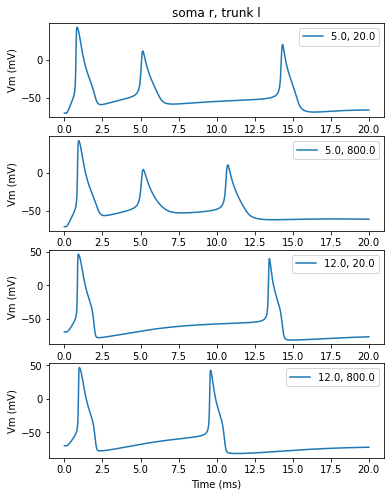

In [7]:
sim.set_gmax(gmax_range[1])
sim.run_neuron_sim()

print("Number of valid sample: %d" % (valid_count(sim)))
_ = plot_v(sim, geo_idx, geo_values)

#### Simulate samples in grid of parameter space

In [8]:
ngmax = 6  # number of gmax values
npoints = 6  # number of geometry parameter values
square_soma_r = True  # Using soma_r^2
geo_var = []
for x in geo_range:
    if square_soma_r and x[0]==0:  # Using soma_r^2
        geo_var.append((x[0],np.linspace(*np.array(x[1])**2,num=npoints)**0.5))
    else:
        geo_var.append((x[0],np.linspace(*x[1],num=npoints)))
gmax_var = np.linspace(*gmax_range,num=ngmax)

sim, geo_idx, geo_values = sim_builder(geo_var,gmax=gmax)

if square_soma_r: geo_values[:,np.nonzero(np.array(geo_idx)==0)[0]] **= 2  # Using soma_r^2

Run simulations

In [9]:
spike_count = np.empty(ngmax,dtype=object)

for i in range(ngmax):
    sim.set_gmax(gmax_var[i])
    sim.run_neuron_sim()
    spike_count[i] = sim.get_spike_number('all')

spike_count = np.vstack(spike_count)

Need the following in case, when gmax increases, spike amplitude in some cell drops below threshold, resulting in decreasing spike count

In [10]:
for i in range(1,ngmax):
    spike_count[i] = np.maximum(spike_count[i-1],spike_count[i])
print(spike_count)

[[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 2 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 1 1 2 2 2 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 1 1 1 1 2 2 1 1 1 1 1 2]
 [3 2 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2]]


Get index of valid samples with only one spike.

In [11]:
valid_samples = spike_count.ravel()==1
grid_shape = tuple(np.concatenate(([ngmax],np.repeat(npoints,len(geo_range)))))
valid_grid = valid_samples.reshape(grid_shape)
print(valid_grid.astype(int))

[[[0 0 0 0 0 0]
  [1 0 0 0 0 0]
  [1 0 0 0 0 0]
  [1 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]]

 [[1 1 1 1 1 1]
  [1 1 1 1 1 1]
  [1 1 1 1 1 1]
  [1 1 1 1 1 1]
  [1 1 1 1 1 1]
  [1 1 1 1 1 1]]

 [[1 1 1 0 0 0]
  [1 1 1 1 1 0]
  [1 1 1 1 1 1]
  [1 1 1 1 1 1]
  [1 1 1 1 1 1]
  [1 1 1 1 1 1]]

 [[0 0 0 0 0 0]
  [0 1 1 0 0 0]
  [1 1 1 1 0 0]
  [1 1 1 1 1 0]
  [1 1 1 1 1 1]
  [1 1 1 1 1 1]]

 [[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 1 1 0 0 0]
  [1 1 1 1 0 0]
  [1 1 1 1 1 0]]

 [[0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 1 1 0 0 0]]]


Get training samples. Method 1: all valid samples. Method 2: averaged gmax of valid samples.

In [12]:
# Method 1
geo_samples = np.tile(geo_values,(ngmax,1))
gmax_samples = np.repeat(gmax_var,geo_values.shape[0]).reshape(-1,1)

# Method 2
valid_grid = valid_samples.reshape(grid_shape[0],np.prod(grid_shape[1:])).T
gmax_avg = np.array([[gmax_var[v].mean()] for v in valid_grid])

Visualizing result

<IPython.core.display.Javascript object>


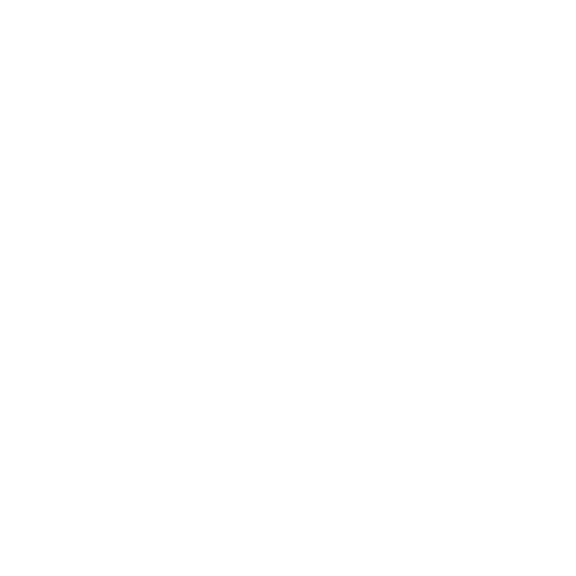

In [13]:
%matplotlib notebook

geo_show = [0,1]
label_names = []
for i in geo_show:
    idx = geo_idx[i]
    label_names.append(geo_name[idx])
    if square_soma_r and idx==0: label_names[-1] += '^2'  # Using soma_r^2

plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(geo_samples[valid_samples,geo_show[0]],geo_samples[valid_samples,geo_show[1]],
             gmax_samples[valid_samples,0],c=gmax_samples[valid_samples,0],cmap='summer',marker='.')
ax.scatter3D(geo_values[:,geo_show[0]],geo_values[:,geo_show[1]],gmax_avg[:,0],c='r',marker='^')
ax.set_xlabel(label_names[0])
ax.set_ylabel(label_names[1])
ax.set_zlabel('gmax')
plt.show()

#### Fit regressor to valid samples.

In [18]:
# Method 1
# x_train = geo_samples[valid_samples]
# y_train = gmax_samples[valid_samples]

# Method 2
x_train = geo_values
y_train = gmax_avg

classifier = ClassifierBuilder(x_train, y_train, ClassifierTypes.LINEAR_REGRESSION)
classifier.fit()
classifier.save_clf(paths.RESOURCES_ROOT + "gmax_lin_reg_classifier.joblib")
lin_pred = classifier.predict(geo_values)

classifier = ClassifierBuilder(x_train, y_train, ClassifierTypes.RIDGE_REGRESSION)
classifier.fit()
classifier.save_clf(paths.RESOURCES_ROOT + "gmax_ridge_classifier.joblib")
rid_pred = classifier.predict(geo_values)


classifier = ClassifierBuilder(x_train, y_train.ravel(), ClassifierTypes.SUPPORT_VECTOR_REGRESSION)
classifier.fit()
classifier.save_clf(paths.RESOURCES_ROOT + "gmax_svr_classifier.joblib")
svr_pred = classifier.predict(geo_values)

(36, 2)


<IPython.core.display.Javascript object>


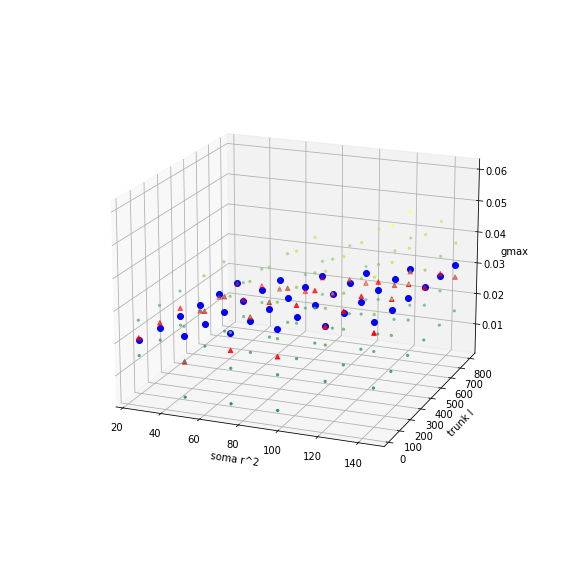

In [15]:
%matplotlib notebook

geo_show = [0,1]
label_names = []
for i in geo_show:
    idx = geo_idx[i]
    label_names.append(geo_name[idx])
    if square_soma_r and idx==0: label_names[-1] += '^2'  # Using soma_r^2

plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(geo_samples[valid_samples,geo_show[0]],geo_samples[valid_samples,geo_show[1]],
             gmax_samples[valid_samples,0],c=gmax_samples[valid_samples,0],cmap='summer',marker='.')
ax.scatter3D(geo_values[:,geo_show[0]],geo_values[:,geo_show[1]],gmax_avg[:,0],c='r',marker='^')
ax.plot3D(geo_values[:,geo_show[0]],geo_values[:,geo_show[1]],lin_pred[:,0],'bo')
# ax.plot3D(geo_values[:,geo_show[0]],geo_values[:,geo_show[1]],rid_pred[:,0],'ro')
# ax.plot3D(geo_values[:,geo_show[0]],geo_values[:,geo_show[1]],svr_pred,'go')
ax.set_xlabel(label_names[0])
ax.set_ylabel(label_names[1])
ax.set_zlabel('gmax')
plt.show()

#### Check predicted gmax performance

In [16]:
sim, geo_idx, _ = sim_builder(geo_var,gmax=lin_pred)
sim.run_neuron_sim()

In [17]:
print("Number of valid sample: %d out of %d" % (valid_count(sim),sim.ncell))
spike_count = sim.get_spike_number('all').reshape(grid_shape[1:])
print(spike_count)

Number of valid sample: 36 out of 36
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]
